# Two Sector Hank (Formal and Informal with Labor Mobility)

## Test: No labor Mobility and equal Sectors

### Option 1:
There is a continuum of ex-ante identical households. They can either work in Sector $f$ or $i$. Given a markov transition matrix.

\begin{align}
    \begin{pmatrix}
        p(f \to f) & p(f \to i) \\
        p(i \to f) & p(i \to i)
    \end{pmatrix}
\end{align}

Given this matrix, the agent can have two different transitory or permanent shocks.
We can also include taxes only for the formal sector by calculating z = (1 - tax) * psi_f 

### To Do:
- Borrowing Constraint for different Markov States
- Transition Matrices
- Jacobians

In [117]:
from HARK.ConsumptionSaving.ConsMarkovModel import MarkovConsumerType
from HARK.ConsumptionSaving.ConsIndShockModel import init_idiosyncratic_shocks
from HARK.distribution import DiscreteDistributionLabeled
import matplotlib.pyplot as plt
from ConsIndShockModel_HANK import HANKIncShkDstn

from TwoSectorModel_HANK import TwoSectorMarkovConsumerType
import numpy as np
from copy import copy, deepcopy
### TESTING LIFECYCLE MODEL

# Define the Markov transition matrix for sector f(ormal) to i(nformal)
p_f_to_i = 0.0 #0.2
p_i_to_f = 0.0 #0.2
p_f_to_f = 1 - p_f_to_i
p_i_to_i = 1 - p_i_to_f

MrkvArray = np.array(
    [
        [
            p_f_to_f
        ,
            p_f_to_i
        ],
        [
           p_i_to_f
        ,
            p_i_to_i
        ]
    ]
)

NSectors = 2

r_ss = 1.03 - 1
G_ss = .2
B_ss = 0.25 # this is lower than the tutorial by Straub et al. because need Higher MPC
Y_ss = 1.0

T_cycles = 1
cycles = 0
LivPrb = 0.99375
init_twosector = {
    "cycles" : cycles,
    "T_cycle" : T_cycles,
    # Parameters shared with the perfect foresight model
    "DiscFac": 0.97,
    "Rfree": np.array(2 * [1.0 + r_ss]),                   # Interest factor on assets
    # "LivPrb" : [np.array([0.06, 0.06])] * T_cycles,                   # Survival probability

    ### Two Sector Model Parameters
    # "MrkvPermShkStd": [np.array([0.06, 0.06])] * T_cycles,  # Standard deviation of log permanent shocks to income for each sector
    # "MrkvTranShkStd": [np.array([0.2, 0.2])] * T_cycles,  # Standard deviation of log transitory shocks to income for each sector
    # "MrkvUnempPrb": [np.array([0.0, 0.0])] * T_cycles,  # Probability of unemployment while working for each sector
    # "MrkvIncUnemp": [np.array([0.0, 0.0])] * T_cycles,  # Unemployment benefits replacement rate for each sector
    # "Mrkvtaxrate": [np.array([0.0, 0.0])] * T_cycles,  # Tax Rate for each sector
    # "Mrkvlabor": [np.array([1.0, 1.0])] * T_cycles,  # Labor for each sector
    # "Mrkvwage": [np.array([1.0, 1.0])] * T_cycles,  # Wage for each sector
    # "BoroCnstArt": [None, 0.0],  # Borrowing constraint for the minimum allowable assets to end the period with  
    "PermShkStd": [np.array([0.06, 0.06])] * T_cycles,  # Standard deviation of log permanent shocks to income for each sector
    "TranShkStd": [np.array([0.2, 0.2])] * T_cycles,  # Standard deviation of log transitory shocks to income for each sector
    "UnempPrb": [np.array([0.0, 0.0])] * T_cycles,  # Probability of unemployment while working for each sector
    "IncUnemp": [np.array([0.0, 0.0])] * T_cycles,  # Unemployment benefits replacement rate for each sector
    "taxrate": [np.array([0.0, 0.0])] * T_cycles,  # Tax Rate for each sector
    "labor": [np.array([1.0, 1.0])] * T_cycles,  # Labor for each sector
    "wage": [np.array([1.0, 1.0])] * T_cycles,  # Wage for each sector
    "BoroCnstArt": [None, 0.0],  # Borrowing constraint for the minimum allowable assets to end the period with  
    "LivPrb": [LivPrb * np.ones(2)] * T_cycles,
    "PermGroFac": [1.0 * np.ones(2)] * T_cycles,
    # Parameters that specify the income distribution over the lifecycle
    # "PermShkStd" : [.06] * T_cycles,                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    # "TranShkStd" : [0.2]* T_cycles,                  # Standard deviation of log transitory shocks to income
    "TranShkCount" : 5,    
    
    # HANK params
    # "taxrate" : [0.0] * T_cycles, # set to 0.0 because we are going to assume that labor here is actually after tax income
    # "labor": [1.0] * T_cycles,
    # "wage": [1.0] * T_cycles,    
    
    # Number of points in discrete approximation to transitory income shocks
    # "UnempPrb" : 0.0,                      # Probability of unemployment while working
    # "IncUnemp" :  0.0,                     # Unemployment benefits replacement rate
  
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    # "BoroCnstArt": 0.0,
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
    
     ### Markov Parameters
    "MrkvArray": [MrkvArray] * T_cycles,  # Transition Matrix for Markov Process
    "global_markov": False,  # If True, then the Markov Process is the same for all agents
    "MrkvPrbsInit": [0.8, 0.2],

    
}

# to add taxes, labor, and wage. This ensures that we can shock each variable.
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

init_twosector['TranShkMean_Func'] = [function]

# Make a consumer with serially correlated unemployment, subject to boom and bust cycles
# init_twosector = copy(init_idiosyncratic_shocks)
# init_twosector["MrkvArray"] = [MrkvArray]
# init_twosector["UnempPrb"] = 0.0  # to make income distribution when employed
init_twosector["global_markov"] = False

### Use the HARK one and add a different wage rate and tax process
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z


In [118]:
TwoSectorExampleHANK = TwoSectorMarkovConsumerType(**init_twosector)


In [119]:
### RFREE WITH TIME VARYING
TwoSectorExampleHANK.assign_parameters(
    Rfree=[np.array(2 * [1.03])] * T_cycles
)

In [120]:
TwoSectorExampleHANK.solve()
print(TwoSectorExampleHANK.completed_cycles)


c:\Users\adria\anaconda3\envs\python390\lib\site-packages\HARK\interpolation.py:2187: RuntimeWarning: All-NaN slice encountered
  y = self.compare(fx, axis=1)


158


In [121]:
### Plot Consumption Functions
mGrid = np.linspace(0, 10, 200)
mGrid = mGrid - 2

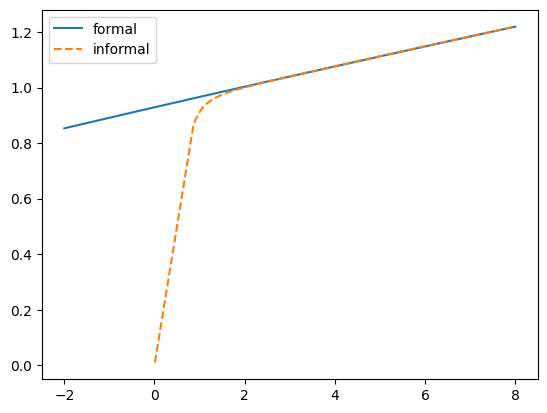

In [122]:
plt.plot(mGrid, TwoSectorExampleHANK.solution[0].cFunc[0](mGrid), label = 'formal')
plt.plot(mGrid, TwoSectorExampleHANK.solution[0].cFunc[1](mGrid), '--', label = 'informal')
plt.legend()

In [123]:
TwoSectorExampleHANK.compute_steady_state()


(3.40918909335442, 1.0927798351110725)

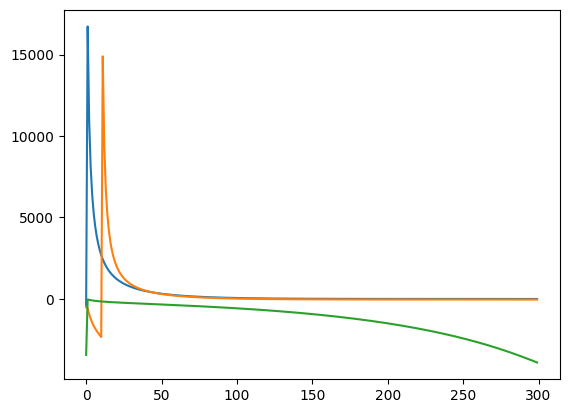

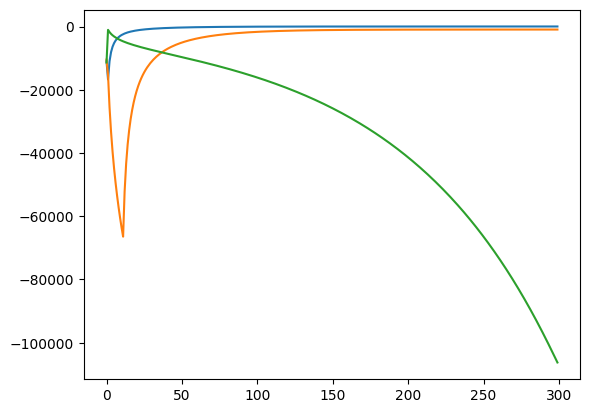

In [124]:
CJACR, AJACR = TwoSectorExampleHANK.calc_jacobian("Rfree", 300)
plt.plot(CJACR[0])
plt.plot(CJACR[10])
plt.plot(CJACR[-1])
plt.show()

plt.plot(AJACR[0])
plt.plot(AJACR[10])
plt.plot(AJACR[-1])

plt.show()

In [125]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
from HARK.ConsumptionSaving.ConsMarkovModel import MarkovConsumerType
from HARK.ConsumptionSaving.ConsIndShockModel import init_idiosyncratic_shocks
from HARK.distribution import DiscreteDistributionLabeled
import matplotlib.pyplot as plt
from ConsIndShockModel_HANK import HANKIncShkDstn
# from HARK.utilities import jump_to_grid_1D, jump_to_grid_2D
import numba

from TwoSectorModel_HANK import TwoSectorMarkovConsumerType
import numpy as np
from copy import copy, deepcopy

In [ ]:
# Define the Markov transition matrix for sector f(ormal) to i(nformal)
p_f_to_i = 0
p_i_to_f = 0
p_f_to_f = 1 - p_f_to_i
p_i_to_i = 1 - p_i_to_f

MrkvArray = np.array(
    [
        [
            p_f_to_f
        ,
            p_f_to_i
        ],
        [
           p_i_to_f
        ,
            p_i_to_i
        ]
    ]
)

NSectors = 2

In [ ]:

r_ss = 1.03 - 1
G_ss = .2
B_ss = 0.25 # this is lower than the tutorial by Straub et al. because need Higher MPC
Y_ss = 1.0
T_cycles = 1
cycles = 0
LivPrb = .99375

init_twosector = {
    "cycles" : cycles,
    # "T_cycle" : T_cycles,
    # Parameters shared with the perfect foresight model
    "DiscFac": 0.97,
    "Rfree": np.array(2 * [1.0 + r_ss]),                   # Interest factor on assets

    ### Two Sector Model Parameters
    "PermShkStd": [np.array([0.06, 0.06])] * T_cycles,  # Standard deviation of log permanent shocks to income for each sector
    "TranShkStd": [np.array([0.2, 0.2])] * T_cycles,  # Standard deviation of log transitory shocks to income for each sector
    "UnempPrb": [np.array([0.0, 0.0])] * T_cycles,  # Probability of unemployment while working for each sector
    "IncUnemp": [np.array([0.0, 0.0])] * T_cycles,  # Unemployment benefits replacement rate for each sector
    "taxrate": [np.array([0.0, 0.0])] * T_cycles,  # Tax Rate for each sector
    "labor": [np.array([1.0, 1.0])] * T_cycles,  # Labor for each sector
    "wage": [np.array([1.0, 1.0])] * T_cycles,  # Wage for each sector
    "BoroCnstArt": [0.0, 0.0],  # Borrowing constraint for the minimum allowable assets to end the period with  
    "LivPrb": [LivPrb * np.ones(2)] * T_cycles,
    "PermGroFac": [1.0 * np.ones(2)] * T_cycles,
    # Parameters that specify the income distribution over the lifecycle
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkCount" : 5,    
    
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
    
     ### Markov Parameters
    "MrkvArray": [MrkvArray] * T_cycles,  # Transition Matrix for Markov Process
    "global_markov": False,  # If True, then the Markov Process is the same for all agents
    "MrkvPrbsInit": [0.5, 0.5],
}


# to add taxes, labor, and wage. This ensures that we can shock each variable.
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

init_twosector['TranShkMean_Func'] = [function]

In [ ]:
# Make a consumer with serially correlated unemployment, subject to boom and bust cycles
init_twosector["global_markov"] = False
TwoSectorExample = TwoSectorMarkovConsumerType(**init_twosector)


In [ ]:
### RFREE WITH TIME VARYING
TwoSectorExample.assign_parameters(
    Rfree=[np.array(2 * [1.0 + r_ss])] * T_cycles
)

In [ ]:
TwoSectorExample.solve()


c:\Users\adria\anaconda3\envs\python390\lib\site-packages\HARK\interpolation.py:2187: RuntimeWarning: All-NaN slice encountered
  y = self.compare(fx, axis=1)


In [ ]:
TwoSectorExample.cycles

0

In [ ]:
# TwoSectorExample.completed_cycles

In [ ]:
vars(TwoSectorExample.solution[0])

{'cFunc': [<HARK.interpolation.LowerEnvelope at 0x25cc41dc5e0>,
 'vFunc': [<HARK.utilities.NullFunc at 0x25cc41dc3d0>,
 'vPfunc': [<HARK.interpolation.MargValueFuncCRRA at 0x25cc41dc4c0>,
 'vPPfunc': [<HARK.utilities.NullFunc at 0x25cc41dcf10>,
 'mNrmMin': array([0., 0.]),
 'hNrm': array([1.9134697, 1.9134697]),
 'MPCmin': array([0.34444026, 0.34444026]),
 'MPCmax': array([1., 1.])}

In [ ]:
### Plot Consumption Functions
mGrid = np.linspace(0, 10, 200)
mGrid = mGrid - 2

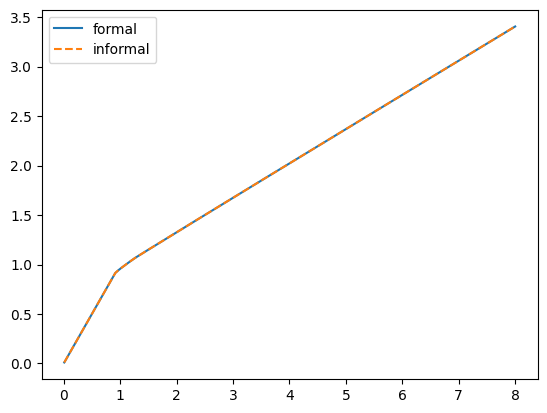

In [ ]:
plt.plot(mGrid, TwoSectorExample.solution[0].cFunc[0](mGrid), label = 'formal')
plt.plot(mGrid, TwoSectorExample.solution[0].cFunc[1](mGrid), '--', label = 'informal')
plt.legend()

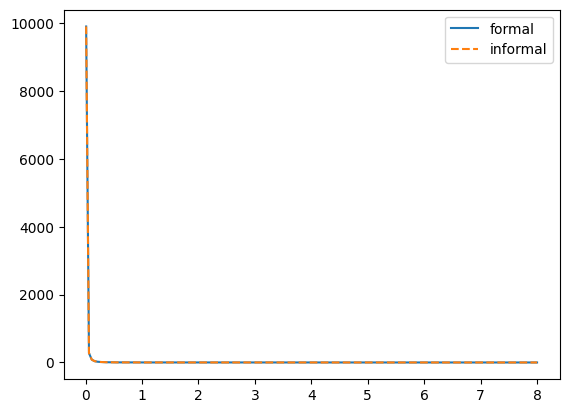

In [ ]:
plt.plot(mGrid, TwoSectorExample.solution[0].vPfunc[0](mGrid), label = 'formal')
plt.plot(mGrid, TwoSectorExample.solution[0].vPfunc[1](mGrid), '--', label = 'informal')
plt.legend()

In [ ]:
stop

In [ ]:
TwoSectorExample.compute_steady_state()

(0.14139303906287626, 1.0011199518594887)

In [ ]:
CJACR, AJACR = TwoSectorExample.calc_jacobian("Rfree", 300)

c:\Users\adria\anaconda3\envs\python390\lib\site-packages\HARK\interpolation.py:2187: RuntimeWarning: All-NaN slice encountered
  y = self.compare(fx, axis=1)


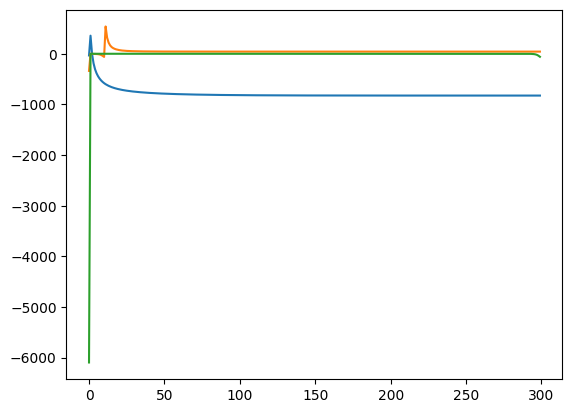

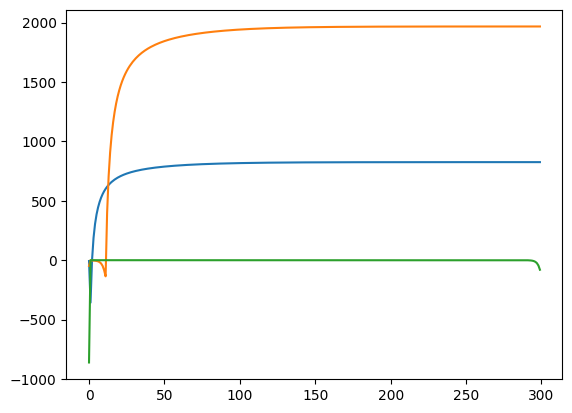

In [ ]:
plt.plot(CJACR[0])
plt.plot(CJACR[10])
plt.plot(CJACR[-1])
plt.show()

plt.plot(AJACR[0])
plt.plot(AJACR[10])
plt.plot(AJACR[-1])

plt.show()

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
### Try new Type
TwoSectorExampleHANK = TwoSectorMarkovConsumerType(**init_twosector)
# TwoSectorExampleHANK = MarkovConsumerType(**init_twosector)
TwoSectorExampleHANK.IncShkDstn = [
    [
        formal_income_dist_HANK,
        informal_income_dist_HANK,
    ]
]

# Time varying shape
TwoSectorExampleHANK.assign_parameters(
    Rfree=np.array(NSectors * [TwoSectorExampleHANK.Rfree])
)

TwoSectorExampleHANK.PermGroFac = [
    np.array(NSectors * TwoSectorExampleHANK.PermGroFac)
]
TwoSectorExampleHANK.LivPrb = [TwoSectorExampleHANK.LivPrb * np.ones(NSectors)]

TwoSectorExampleHANK.BoroCnstArt = np.array([-10.0, -1.0])

TwoSectorExampleHANK.cycles = 0
TwoSectorExampleHANK.vFuncBool = False 

In [ ]:
TwoSectorExampleHANK.MrkvArray

[array([[1., 0.],
        [0., 1.]])]

In [ ]:
TwoSectorExampleHANK.BoroCnstArt

array([-10.,  -1.])

array([1.03, 1.03])

In [ ]:
TwoSectorExampleHANK.solve()

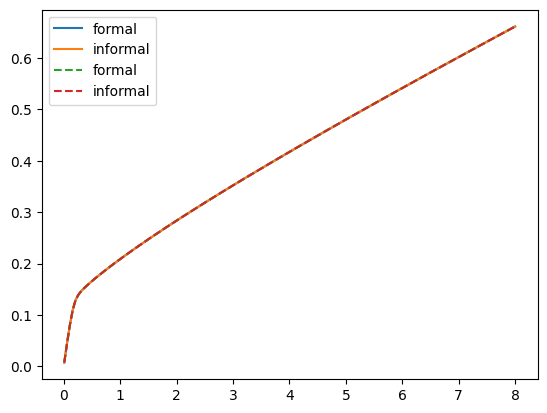

In [ ]:
plt.plot(mGrid, TwoSectorExample.solution[0].cFunc[0](mGrid), label = 'formal')
plt.plot(mGrid, TwoSectorExample.solution[0].cFunc[1](mGrid), label = 'informal')
plt.plot(mGrid, TwoSectorExampleHANK.solution[0].cFunc[0](mGrid), '--', label = 'formal')
plt.plot(mGrid, TwoSectorExampleHANK.solution[0].cFunc[1](mGrid), '--', label = 'informal')
plt.legend()

### Two Borrowing Constraints don't make a difference
- The reason is that even with a small probability risk to transition to the informal sector and becoming uneployed, the potential income is 0. Note that the agent could become unemployed all the time. If the agent would have debt prior to transitioning to the informal sector, the agent would need to repay it, but could not.


In [ ]:
### Simulate
TwoSectorExampleHANK.T_sim = 10
TwoSectorExampleHANK.MrkvPrbsInit = [0.8, 0.2]
TwoSectorExampleHANK.track_vars = ["mNrm", "cNrm"]
TwoSectorExampleHANK.aNrmInitMean = np.log(0.0) 
TwoSectorExampleHANK.make_shock_history()  # This is optional
TwoSectorExampleHANK.initialize_sim()
TwoSectorExampleHANK.simulate()

C:\Users\adria\AppData\Local\Temp\ipykernel_17424\1462389146.py:5: RuntimeWarning: divide by zero encountered in log
  TwoSectorExampleHANK.aNrmInitMean = np.log(0.0)


{'mNrm': array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 1.92301674,  2.97617851,  3.44885051, ...,  2.58744831,
          1.73157521,  1.3507589 ],
        [ 3.9203177 ,  8.77461525,  4.84863945, ...,  3.12433882,
          2.6676122 ,  2.94620512],
        ...,
        [19.20003767, 12.53451634,  1.55441511, ..., 20.20403749,
          5.34044527, 11.69069898],
        [ 1.        , 10.16145085,  2.48395124, ..., 19.62364449,
          8.56505768,  5.67852864],
        [ 1.88378475, 10.18749133,  4.25120558, ..., 18.63191154,
         12.71539869, 16.6293588 ]]),
 'cNrm': array([[0.20867813, 0.20867813, 0.20867813, ..., 0.20867813, 0.20867813,
         0.20867813],
        [0.27807442, 0.3504237 , 0.38156073, ..., 0.32430985, 0.26428529,
         0.23603638],
        [0.4120234 , 0.70637794, 0.47059412, ..., 0.36027504, 0.32972015,
         0.34843074],
        ...,
        [1.29580589, 0.92295572, 0.25129215, ..., 1.3512

In [ ]:
np.mean(TwoSectorExampleHANK.history['cNrm'])

0.9115010872952471

In [ ]:
np.mean(TwoSectorExampleHANK.history['mNrm'])

13.20419745677602

In [ ]:
TwoSectorExampleHANK.Rfree

array([1.03, 1.03])

### Transitionmatrix test

In [ ]:
TwoSectorExampleHANK.mCount = 100
TwoSectorExampleHANK.mFac = 3
TwoSectorExampleHANK.mMin = 0.001
TwoSectorExampleHANK.mMax = 1000
TwoSectorExampleHANK.neutral_measure = True

In [ ]:
TwoSectorExampleHANK.define_distribution_grid()

In [ ]:
TwoSectorExampleHANK.cycles
TwoSectorExampleHANK.MrkvPrbsInit

[0.8, 0.2]

In [ ]:
TwoSectorExampleHANK.calc_transition_matrix_Markov()

In [ ]:
TwoSectorExampleHANK.calc_ergodic_dist_Markov()

In [ ]:
TwoSectorExampleHANK.compute_steady_state()

(392.2496144457125, 19.72164758652894)

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
tran_matrix = TwoSectorExampleHANK.tran_matrix

AttributeError: 'TwoSectorMarkovConsumerType' object has no attribute 'tran_matrix'

In [ ]:
TwoSectorExampleHANK.calc_ergodic_dist()

AttributeError: 'TwoSectorMarkovConsumerType' object has no attribute 'tran_matrix'

In [ ]:
def gen_tran_matrix_1D_Markov(
    dist_mGrid, MrkvPrbs, bNext_Grid, shk_prbs, perm_shks, tran_shks, LivPrb, NewBornDist
):
    """
    Computes Transition Matrix across normalized market resources.
    This function is built to non-stochastic simulate the IndShockConsumerType.
    This function is used exclusively when Harmenberg Neutral Measure is applied and/or if permanent income is not a state variable
    For more information, see https://econ-ark.org/materials/harmenberg-aggregation?launch

    Parameters
    ----------
    dist_mGrid : np.array
        Grid over normalized market resources

    MrkvPrbs : np.array
        Probabilities of transitioning between different states of the Markov process

    bNext_Grid : Lif of np.array
        Grid over bank balances

    shk_prbs : np.array
        Array of shock probabilities over combinations of permanent and transitory shocks

    perm_shks : np.array
        Array of shocks to permanent income. Shocks should follow Harmenberg neutral measure

    tran_shks : np.array
        Array of shocks to transitory

    LivPrb : float
        Probability of not dying

    NewBornDist : np.array
        array representing distribution of newborns across grid of normalized market resources and grid of permanent income.

    Returns
    -------
    TranMatrix : np.array
        Transition Matrix over normalized market resources grid.


    """

    TranMatrix = np.zeros((len(MrkvPrbs) * len(dist_mGrid), len(MrkvPrbs) * len(dist_mGrid)))
    TranMatrix_NoMrkv_List = []

    for Mrkv in numba.prange(len(MrkvPrbs)): #For each state of the Markov process (formal and informal sector)
        TranMatrix_NoMrkv_array = np.zeros((len(dist_mGrid), len(dist_mGrid)))
        for i in numba.prange(len(dist_mGrid)):
            mNext_ij = (
                bNext_Grid[Mrkv][i] / perm_shks[Mrkv] + tran_shks[Mrkv]
            )  # Compute next period's market resources given todays bank balances bnext[i]

            TranMatrix_NoMrkv_array[:, i] += (
                LivPrb[Mrkv] * jump_to_grid_1D(mNext_ij, shk_prbs[Mrkv], dist_mGrid)
                + (1.0 - LivPrb[Mrkv]) * NewBornDist[Mrkv]) # Given state of the Markov Process

        TranMatrix_NoMrkv_List.append(TranMatrix_NoMrkv_array)

    # Fill the upper left corner of TranMatrix
    TranMatrix[:100, :100] = TranMatrix_NoMrkv_List[0] * MrkvPrbs[0, 0]

    # Fill the upper right corner of TranMatrix
    TranMatrix[:100, 100:] = TranMatrix_NoMrkv_List[0] * MrkvPrbs[0, 1]

    # Fill the lower left corner of TranMatrix
    TranMatrix[100:, :100] = TranMatrix_NoMrkv_List[1] * MrkvPrbs[1, 0]

    # Fill the lower right corner of TranMatrix
    TranMatrix[100:, 100:] = TranMatrix_NoMrkv_List[1] * MrkvPrbs[1, 1]

    return TranMatrix

In [ ]:
def calc_transition_matrix_Markov(self, shk_dstn=None):
    """
    Calculates how the distribution of agents across market resources
    transitions from one period to the next. If finite horizon problem, then calculates
    a list of transition matrices, consumption and asset policy grids for each period of the problem.
    The transition matrix/matrices and consumption and asset policy grid(s) are stored as attributes of self.


    Parameters
    ----------
        shk_dstn: list
            list of income shock distributions. Each Income Shock Distribution should be a DiscreteDistribution Object (see Distribution.py)
    Returns
    -------
    None

    """

    if self.cycles == 0:  # Infinite Horizon Problem
        if not hasattr(shk_dstn, "pmv"):
            shk_dstn = self.IncShkDstn

        dist_mGrid = self.dist_mGrid  # Grid of market resources
        dist_pGrid = self.dist_pGrid  # Grid of permanent incomes

        MrkvPrbs = self.MrkvArray  # Transition Matrix for Markov Process
        MrkvPrbsInit = self.MrkvPrbsInit # Initial Markov State Probabilities

        # Loop over Markov States
        self.cPol_Grid = []  # List of consumption policy grids for each Markov state
        self.aPol_Grid = []  # List of asset policy grids for each Markov state
        bNext_Grid = []  # List of bank balance grids for each period in T_cycle

        shk_prbs = []
        tran_shks = []
        perm_shks = []
        LivPrb = []
        for i in range(len(MrkvPrbs)):
            Cnow = self.solution[0].cFunc[i](dist_mGrid)
            self.cPol_Grid.append(Cnow)  # Add to list
            aNext = dist_mGrid - Cnow  # Asset policy grid in period k
            self.aPol_Grid.append(aNext)  # Add to list
                    
            if type(TwoSectorExampleHANK.Rfree) == list:
                bNext = TwoSectorExampleHANK.Rfree[0][i] * aNext
            else:
                bNext = TwoSectorExampleHANK.Rfree[i] * aNext
            bNext_Grid.append(bNext)

            # Obtain shocks and shock probabilities from income distribution this period
            shk_prbs.append(shk_dstn[0][i].pmv)   # Probability of shocks this period
            # Transitory shocks this period
            tran_shks.append(shk_dstn[0][i].atoms[1])
            # Permanent shocks this period
            perm_shks.append(shk_dstn[0][i].atoms[0])

            # Update probability of staying alive this period
            LivPrb.append(self.LivPrb[0][i])
      
        if len(dist_pGrid) == 1:
            # New borns have this distribution (assumes start with no assets and permanent income=1)
            NewBornDist_list = []  # To store modified NewBornDist arrays

            # Iterate over each element in MrkvPrbsInit and modify NewBornDist
            for Mrkv, prob in enumerate(MrkvPrbsInit):
                NewBornDist_array = jump_to_grid_1D(
                                    np.zeros_like(tran_shks[Mrkv]), # No shocks at the beginning. Therefore, does not matter which shocks I take
                                    shk_prbs[Mrkv],
                                    dist_mGrid,) * prob
                NewBornDist_list.append(NewBornDist_array)

            # Stack all modified arrays
            NewBornDist = np.vstack(NewBornDist_list)

            # Compute Transition Matrix given shocks and grids.
            TranMatrix_M = gen_tran_matrix_1D_Markov(
                dist_mGrid,
                MrkvPrbs,
                bNext_Grid,
                shk_prbs,
                perm_shks,
                tran_shks,
                LivPrb,
                NewBornDist,
            )
            
            self.tran_matrix.append(TranMatrix_M)   
            
                     


In [ ]:
TwoSectorExampleHANK.mCount = 100
TwoSectorExampleHANK.mFac = 3
TwoSectorExampleHANK.mMin = 0.001
TwoSectorExampleHANK.mMax = 1000

In [ ]:
TwoSectorExampleHANK.define_distribution_grid()

In [ ]:
dist_mGrid = TwoSectorExampleHANK.dist_mGrid
MrkvPrbsInit = TwoSectorExampleHANK.MrkvPrbsInit
MrkvPrbs = MrkvArray
shk_dstn = TwoSectorExampleHANK.IncShkDstn

In [ ]:
cPol_Grid = []
aPol_Grid = []
bNext_Grid = []

In [ ]:
shk_prbs = []
tran_shks = []
perm_shks = []
LivPrb = []
for i in range(len(MrkvPrbs)):
    Cnow = TwoSectorExampleHANK.solution[0].cFunc[i](dist_mGrid)
    cPol_Grid.append(Cnow)  # Add to list
    aNext = dist_mGrid - Cnow  # Asset policy grid in period k
    aPol_Grid.append(aNext)  # Add to list
            
    if type(TwoSectorExampleHANK.Rfree) == list:
        bNext = TwoSectorExampleHANK.Rfree[0][i] * aNext
    else:
        bNext = TwoSectorExampleHANK.Rfree[i] * aNext
    bNext_Grid.append(bNext)
    # Obtain shocks and shock probabilities from income distribution this period
    shk_prbs.append(shk_dstn[0][i].pmv)   # Probability of shocks this period
    # Transitory shocks this period
    tran_shks.append(shk_dstn[0][i].atoms[1])
    # Permanent shocks this period
    perm_shks.append(shk_dstn[0][i].atoms[0])

    # Update probability of staying alive this period
    LivPrb.append(TwoSectorExampleHANK.LivPrb[0][i])


In [ ]:
def jump_to_grid_1D(m_vals, probs, Dist_mGrid):
    """
    Distributes values onto a predefined grid, maintaining the means.


    Parameters
    ----------
    m_vals: np.array
            Market resource values

    probs: np.array
            Shock probabilities associated with combinations of m_vals.
            Can be thought of as the probability mass function  of (m_vals).

    dist_mGrid : np.array
            Grid over normalized market resources

    Returns
    -------
    probGrid.flatten(): np.array
             Probabilities of each gridpoint on the combined grid of market resources

    """

    probGrid = np.zeros(len(Dist_mGrid))
    mIndex = np.digitize(m_vals, Dist_mGrid) - 1
    mIndex[m_vals <= Dist_mGrid[0]] = -1
    mIndex[m_vals >= Dist_mGrid[-1]] = len(Dist_mGrid) - 1

    for i in range(len(m_vals)):
        if mIndex[i] == -1:
            mlowerIndex = 0
            mupperIndex = 0
            mlowerWeight = 1.0
            mupperWeight = 0.0
        elif mIndex[i] == len(Dist_mGrid) - 1:
            mlowerIndex = -1
            mupperIndex = -1
            mlowerWeight = 1.0
            mupperWeight = 0.0
        else:
            mlowerIndex = mIndex[i]
            mupperIndex = mIndex[i] + 1
            mlowerWeight = (Dist_mGrid[mupperIndex] - m_vals[i]) / (
                Dist_mGrid[mupperIndex] - Dist_mGrid[mlowerIndex]
            )
            mupperWeight = 1.0 - mlowerWeight

        probGrid[mlowerIndex] += probs[i] * mlowerWeight
        probGrid[mupperIndex] += probs[i] * mupperWeight

    return probGrid.flatten()


In [ ]:
tran_shks

[array([0.        , 0.67957557, 0.79166261, 0.86286617, 0.92880902,
        0.99985475, 1.09014463, 1.2786662 , 0.        , 0.67957557,
        0.79166261, 0.86286617, 0.92880902, 0.99985475, 1.09014463,
        1.2786662 , 0.        , 0.67957557, 0.79166261, 0.86286617,
        0.92880902, 0.99985475, 1.09014463, 1.2786662 , 0.        ,
        0.67957557, 0.79166261, 0.86286617, 0.92880902, 0.99985475,
        1.09014463, 1.2786662 , 0.        , 0.67957557, 0.79166261,
        0.86286617, 0.92880902, 0.99985475, 1.09014463, 1.2786662 ,
        0.        , 0.67957557, 0.79166261, 0.86286617, 0.92880902,
        0.99985475, 1.09014463, 1.2786662 , 0.        , 0.67957557,
        0.79166261, 0.86286617, 0.92880902, 0.99985475, 1.09014463,
        1.2786662 ]),
 array([0.        , 0.39851654, 0.46424659, 0.50600176, 0.54467196,
        0.58633457, 0.63928234, 0.74983512, 0.        , 0.39851654,
        0.46424659, 0.50600176, 0.54467196, 0.58633457, 0.63928234,
        0.74983512, 0.    

In [ ]:
# New borns have this distribution (assumes start with no assets and permanent income=1)
NewBornDist_list = []  # To store modified NewBornDist arrays

# Iterate over each element in MrkvPrbsInit and modify NewBornDist
for Mrkv, prob in enumerate(MrkvPrbsInit):
    NewBornDist_array = jump_to_grid_1D(
                        np.zeros_like(tran_shks[Mrkv]), # No shocks at the beginning. Therefore, does not matter which shocks I take
                        shk_prbs[Mrkv],
                        dist_mGrid,) * prob
    NewBornDist_list.append(NewBornDist_array)

# Stack all modified arrays
NewBornDist = np.vstack(NewBornDist_list)

NameError: name 'MrkvPrbsInit' is not defined

In [ ]:
NewBornDist

array([[0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.

In [ ]:
bNext[0]

0.00029353015605122084

In [ ]:
shk_prbs[0]

array([0.00714286, 0.01938776, 0.01938776, 0.01938776, 0.01938776,
       0.01938776, 0.01938776, 0.01938776, 0.00714286, 0.01938776,
       0.01938776, 0.01938776, 0.01938776, 0.01938776, 0.01938776,
       0.01938776, 0.00714286, 0.01938776, 0.01938776, 0.01938776,
       0.01938776, 0.01938776, 0.01938776, 0.01938776, 0.00714286,
       0.01938776, 0.01938776, 0.01938776, 0.01938776, 0.01938776,
       0.01938776, 0.01938776, 0.00714286, 0.01938776, 0.01938776,
       0.01938776, 0.01938776, 0.01938776, 0.01938776, 0.01938776,
       0.00714286, 0.01938776, 0.01938776, 0.01938776, 0.01938776,
       0.01938776, 0.01938776, 0.01938776, 0.00714286, 0.01938776,
       0.01938776, 0.01938776, 0.01938776, 0.01938776, 0.01938776,
       0.01938776])

In [ ]:
LivPrb

[0.98, 0.98]

In [ ]:
bNext_Grid[0].shape

(100,)

In [ ]:
TranMatrix_NoMrkv_array.shape

(100, 100)

In [ ]:
mNext_ij.shape

(56,)

In [ ]:
shk_prbs[0].shape

(56,)

In [ ]:
dist_mGrid.shape

(100,)

In [ ]:
TranMatrix = np.zeros((len(MrkvPrbs) * len(dist_mGrid), len(MrkvPrbs) * len(dist_mGrid)))
TranMatrix_NoMrkv_List = []

for Mrkv in numba.prange(len(MrkvPrbs)): #For each state of the Markov process (formal and informal sector)
    TranMatrix_NoMrkv_array = np.zeros((len(dist_mGrid), len(dist_mGrid)))
    for i in numba.prange(len(dist_mGrid)):
        mNext_ij = (
            bNext_Grid[Mrkv][i] / perm_shks[Mrkv] + tran_shks[Mrkv]
        )  # Compute next period's market resources given todays bank balances bnext[i]

        TranMatrix_NoMrkv_array[:, i] += (
            LivPrb[Mrkv] * jump_to_grid_1D(mNext_ij, shk_prbs[Mrkv], dist_mGrid)
            + (1.0 - LivPrb[Mrkv]) * NewBornDist[Mrkv]) # Given state of the Markov Process

    TranMatrix_NoMrkv_List.append(TranMatrix_NoMrkv_array)

# Fill the upper left corner of TranMatrix
TranMatrix[:100, :100] = TranMatrix_NoMrkv_List[0] * MrkvPrbs[0, 0]

# Fill the upper right corner of TranMatrix
TranMatrix[:100, 100:] = TranMatrix_NoMrkv_List[0] * MrkvPrbs[0, 1]

# Fill the lower left corner of TranMatrix
TranMatrix[100:, :100] = TranMatrix_NoMrkv_List[1] * MrkvPrbs[1, 0]

# Fill the lower right corner of TranMatrix
TranMatrix[100:, 100:] = TranMatrix_NoMrkv_List[1] * MrkvPrbs[1, 1]

In [ ]:
# Compute Transition Matrix given shocks and grids.
TranMatrix_M = gen_tran_matrix_1D_Markov(
    dist_mGrid,
    MrkvPrbs,
    bNext,
    shk_prbs,
    perm_shks,
    tran_shks,
    LivPrb,
    NewBornDist,
)

IndexError: invalid index to scalar variable.

In [ ]:
TwoSectorExampleHANK.MrkvPrbs

In [ ]:
TwoSectorExampleHANK.calc_transition_matrix_Markov()

AttributeError: 'TwoSectorMarkovConsumerType' object has no attribute 'MrkvPrbs'